In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/example_submission.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv
/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv


# Importing the libraries

In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Dataset

In [3]:
df=pd.read_csv("/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv")
df_test=pd.read_csv("/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv")
df_icml=pd.read_csv("/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv")

In [4]:
print(df.shape)
print(df_test.shape)
print(df_icml.shape)

(28709, 2)
(7178, 1)
(35887, 3)


In [5]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
df_test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [7]:
df_icml.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
print(df_icml.columns.tolist())

['emotion', ' Usage', ' pixels']


In [9]:
df_icml.rename(columns = {' Usage':'usage'}, inplace = True)
df_icml.rename(columns = {' pixels':'pixels'}, inplace = True)

In [10]:
df_icml["usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [11]:
print(np.sum(df_icml["usage"]=="Training"))
print(np.sum(df_icml["usage"]=="PublicTest"))
print(np.sum(df_icml["usage"]=="PrivateTest"))

28709
3589
3589


In [12]:
df_icml = df_icml.loc[df_icml['usage'].isin(['PublicTest', 'PrivateTest'])]
df_icml.shape

(7178, 3)

df = used for training     
df_test, df_icml = used for evaluation and testing  

In [13]:
df_icml

,emotion,usage,pixels
28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


# EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [15]:
print(df["emotion"].unique())

[0 2 4 6 3 5 1]


In [16]:
X = df['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48, 1).astype('float32'))
X = np.stack(X, axis=0)
X.shape

(28709, 48, 48, 1)

In [17]:
y = df["emotion"]
y.shape

(28709,)

In [18]:
emotion = ('anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')

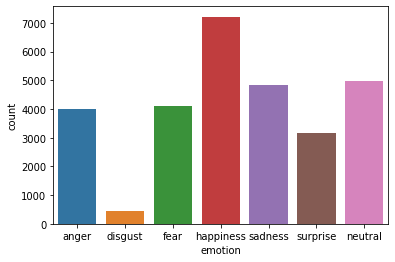

In [19]:
sns.countplot(x=y)
plt.xticks(range(7), emotion);

Text(0.5, 1.0, 'happiness')

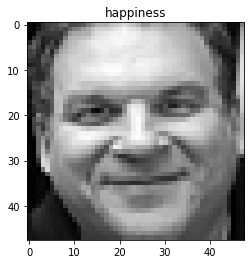

In [20]:
plt.imshow(X[14].reshape((48,48)), cmap='gray')
plt.title(emotion[y[14]])

Text(0.5, 1.0, 'neutral')

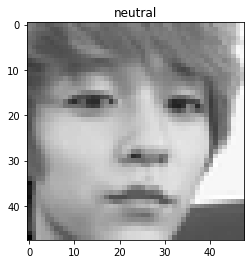

In [21]:
plt.imshow(X[13].reshape((48,48)), cmap='gray')
plt.title(emotion[y[13]])

In [22]:
le = LabelEncoder()
img_labels = le.fit_transform(y)
img_labels = to_categorical(img_labels)
img_labels.shape

(28709, 7)

In [23]:
X.shape,img_labels.shape

((28709, 48, 48, 1), (28709, 7))

In [24]:
X = X/255.

In [25]:
X

array([[[[0.27450982],
         [0.3137255 ],
         [0.32156864],
         ...,
         [0.20392157],
         [0.16862746],
         [0.16078432]],

        [[0.25490198],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862746],
         [0.21176471],
         ...,
         [0.19215687],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490198],
         [0.16470589],
         ...,
         [0.28235295],
         [0.21960784],
         [0.16862746]],

        [[0.3019608 ],
         [0.32156864],
         [0.30980393],
         ...,
         [0.4117647 ],
         [0.27450982],
         [0.18039216]],

        [[0.3019608 ],
         [0.28235295],
         [0.32941177],
         ...,
         [0.41568628],
         [0.42745098],
         [0.32156864]]],


       [[[0.5921569 ],
         [0.5882353 ],
         [0.57

# Training

In [26]:
model = Sequential()

model.add(Conv2D(filters = 64,kernel_size = (5, 5),input_shape = (48, 48, 1),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64,kernel_size = (5, 5),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))


model.add(Flatten(name='flatten'))       
model.add(Dense(512,activation='relu',kernel_initializer='he_normal',))
model.add(BatchNormalization())   
model.add(Dropout(0.6))
model.add(Dense(7,activation='softmax'))

2022-12-19 17:24:02.569279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 17:24:02.674047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 17:24:02.674824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 17:24:02.676006: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

In [28]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=0.00001,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [30]:
gen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True
)
gen.fit(X)

In [31]:
X

array([[[[0.27450982],
         [0.3137255 ],
         [0.32156864],
         ...,
         [0.20392157],
         [0.16862746],
         [0.16078432]],

        [[0.25490198],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862746],
         [0.21176471],
         ...,
         [0.19215687],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490198],
         [0.16470589],
         ...,
         [0.28235295],
         [0.21960784],
         [0.16862746]],

        [[0.3019608 ],
         [0.32156864],
         [0.30980393],
         ...,
         [0.4117647 ],
         [0.27450982],
         [0.18039216]],

        [[0.3019608 ],
         [0.28235295],
         [0.32941177],
         ...,
         [0.41568628],
         [0.42745098],
         [0.32156864]]],


       [[[0.5921569 ],
         [0.5882353 ],
         [0.57

# Applying stratified K-fold accuracy

In [32]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) 
lst_accu_stratified = []

In [33]:
img_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [34]:
y = img_labels
for train_index, test_index in skf.split(X, y.argmax(1)): 
    X_train_fold, X_test_fold = X[train_index], X[test_index] 
    y_train_fold, y_test_fold = y[train_index], y[test_index] 
    history = model.fit(X_train_fold, y_train_fold,epochs=5,callbacks=callbacks,batch_size=32) 
    lst_accu_stratified.append(model.evaluate(X_test_fold, y_test_fold))
    
    plt.show()

2022-12-19 17:24:06.347861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-12-19 17:24:08.624929: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


808/808 [==============================] - 22s 17ms/step - loss: 2.0449 - accuracy: 0.2871
Epoch 2/5
808/808 [==============================] - 14s 17ms/step - loss: 1.5721 - accuracy: 0.3981
Epoch 3/5
808/808 [==============================] - 14s 17ms/step - loss: 1.3573 - accuracy: 0.4779
Epoch 4/5
808/808 [==============================] - 14s 17ms/step - loss: 1.2540 - accuracy: 0.5216
Epoch 5/5
90/90 [==============================] - 1s 8ms/step - loss: 1.1902 - accuracy: 0.5545
Epoch 1/5
808/808 [==============================] - 14s 17ms/step - loss: 1.1358 - accuracy: 0.5751
Epoch 2/5
808/808 [==============================] - 14s 17ms/step - loss: 1.0959 - accuracy: 0.5880
Epoch 3/5
808/808 [==============================] - 14s 17ms/step - loss: 1.0440 - accuracy: 0.6089
Epoch 4/5
808/808 [==============================] - 14s 18ms/step - loss: 1.0134 - accuracy: 0.6204
Epoch 5/5
90/90 [==============================] - 1s 7ms/step - loss: 1.0507 - accuracy: 0.6214
Epoch 1/

In [35]:
print(lst_accu_stratified)

[[1.1901960372924805, 0.5545106530189514], [1.0506678819656372, 0.6213862895965576], [0.9031367897987366, 0.6805990934371948], [0.6330339312553406, 0.7958899140357971], [0.4606667459011078, 0.8568443059921265], [0.2509930729866028, 0.9129223227500916], [0.14867769181728363, 0.9522814154624939], [0.1316213309764862, 0.9592476487159729], [0.0804232731461525, 0.9794496893882751], [0.7270168662071228, 0.9045296311378479]]


In [36]:
acc = 0
for i in lst_accu_stratified:
    acc = acc+i[1]
print("Accuracy",acc/len(lst_accu_stratified))

Accuracy 0.8217660963535309
